<a href="https://colab.research.google.com/github/abkimc/CV-course-test-prepration/blob/main/Image_processing_lecture_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

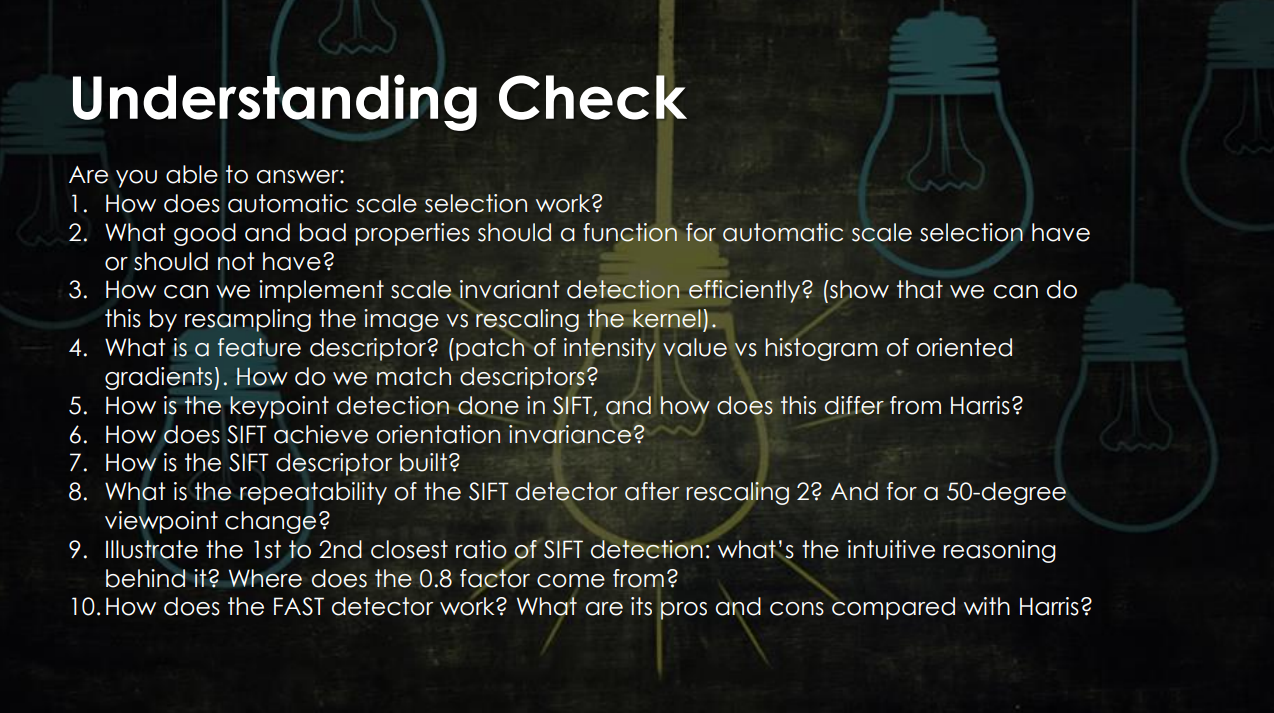

In [ ]:
# How does automatic scale selection work?
"""
we're designing a function that is scaling invariant, it has the same value for corresponding patches
even if they're at different scales so we found the local maximum of this function and then the patch size of the local maximum is reach it should be invariant to the image rescaling

Difference of Gaussians (DoG)
Compute Gaussian Images:

Generate two Gaussian-blurred images at different scales (σ and kσ, where k is a constant factor).

Subtract these two images to obtain the DoG image.

Detect Extrema:

Search for local maxima and minima in the DoG images across scales.

These extrema correspond to potential features.

"""

# What good and bad properties should a function for automatic scale selection have or should not have?

"""
Good properties:

Scale invariance - The selected scale should be proportional to the actual size/scale of the local structure in the image, making the detection independent of the image's resolution or zoom level.
Localization accuracy - The selected scale should accurately correspond to the characteristic size of the local image structure, allowing precise feature detection.
Stability - The scale selection should be stable under small image perturbations, noise, and minor geometric or photometric transformations.
Repeatability - Given similar image structures at different scales, the function should consistently select corresponding scales that maintain the relative size relationships.


Properties to avoid:

Scale quantization bias - The function shouldn't prefer certain discrete scales over others due to implementation details, as this can cause inconsistent detection.
Boundary effects - The scale selection shouldn't be overly influenced by image boundaries or produce unstable results near edges.
Over-smoothing - Excessive smoothing at larger scales can destroy important image details and lead to loss of discriminative information.
Computational inefficiency - The function shouldn't require exhaustive scale-space exploration when more efficient methods exist.
"""







In [ ]:
# How can we implement scale invariant detection efficiently? (show that we can do this by resampling the image vs rescaling the kernel).
import numpy as np
from scipy import ndimage
import cv2
import matplotlib.pyplot as plt

def create_gaussian_kernel(size, sigma):
    """Create a 2D Gaussian kernel."""
    x = np.linspace(-size // 2, size // 2, size)
    y = x[:, np.newaxis]
    gaussian = np.exp(-(x*x + y*y) / (2.0 * sigma * sigma))
    return gaussian / gaussian.sum()

def scale_invariant_detection_image_resampling(image, num_scales=5, initial_sigma=1.0, k=1.4):
    """Scale invariant detection using image resampling approach."""
    responses = []
    scales = []

    # Convert image to float and normalize
    image = image.astype(float) / 255.0

    for i in range(num_scales):
        # Calculate current scale
        current_scale = initial_sigma * (k ** i)
        scales.append(current_scale)

        # Resample image
        scale_factor = 1.0 / current_scale
        scaled_image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor)

        # Apply fixed-size Gaussian kernel
        kernel = create_gaussian_kernel(5, initial_sigma)
        smoothed = ndimage.convolve(scaled_image, kernel)

        # Calculate LoG response (approximate using DoG)
        kernel_smaller = create_gaussian_kernel(5, initial_sigma/1.4)
        smoothed_smaller = ndimage.convolve(scaled_image, kernel_smaller)
        dog_response = smoothed - smoothed_smaller

        # Resize response back to original size
        response = cv2.resize(dog_response, (image.shape[1], image.shape[0]))
        responses.append(response)

    return np.array(responses), scales

def scale_invariant_detection_kernel_scaling(image, num_scales=5, initial_sigma=1.0, k=1.4):
    """Scale invariant detection using kernel rescaling approach."""
    responses = []
    scales = []

    # Convert image to float and normalize
    image = image.astype(float) / 255.0

    for i in range(num_scales):
        # Calculate current scale
        current_scale = initial_sigma * (k ** i)
        scales.append(current_scale)

        # Create Gaussian kernels at different scales
        kernel_size = int(6 * current_scale)  # Ensure kernel covers 3σ on each side
        if kernel_size % 2 == 0:  # Make sure kernel size is odd
            kernel_size += 1

        kernel = create_gaussian_kernel(kernel_size, current_scale)
        kernel_smaller = create_gaussian_kernel(kernel_size, current_scale/1.4)

        # Apply scaled kernels
        smoothed = ndimage.convolve(image, kernel)
        smoothed_smaller = ndimage.convolve(image, kernel_smaller)

        # Calculate LoG response (approximate using DoG)
        dog_response = smoothed - smoothed_smaller
        responses.append(dog_response)

    return np.array(responses), scales

def find_scale_space_extrema(responses, scales, threshold=0.03):
    """Find local extrema in scale space."""
    extrema = []

    # Pad responses for boundary handling
    padded = np.pad(responses, ((0,0), (1,1), (1,1)), mode='edge')

    for s in range(responses.shape[0]):
        for i in range(1, responses.shape[1]-1):
            for j in range(1, responses.shape[2]-1):
                # Get 3x3x3 neighborhood
                neighborhood = responses[max(0,s-1):min(s+2,responses.shape[0]),
                                      i-1:i+2,
                                      j-1:j+2]

                center_value = responses[s,i,j]

                # Check if center is maximum in its neighborhood
                if abs(center_value) > threshold and center_value == neighborhood.max():
                    extrema.append((scales[s], i, j, center_value))

    return extrema

# Visualization function
def visualize_responses_and_extrema(image, responses1, scales1, responses2, scales2, extrema1, extrema2):
    """Visualize the scale-space responses and extrema."""
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    # Original image
    axes[0, 0].imshow(image, cmap='gray')
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis('off')

    # Resampling method response visualization (using first scale response)
    axes[0, 1].imshow(responses1[0], cmap='hot')
    axes[0, 1].set_title(f"Resampling Method - Scale {scales1[0]:.2f}")
    axes[0, 1].axis('off')

    # Kernel scaling method response visualization (using first scale response)
    axes[1, 0].imshow(responses2[0], cmap='hot')
    axes[1, 0].set_title(f"Kernel Scaling Method - Scale {scales2[0]:.2f}")
    axes[1, 0].axis('off')

    # Overlay detected extrema
    axes[1, 1].imshow(image, cmap='gray')
    axes[1, 1].set_title("Detected Extrema")
    for scale, x, y, _ in extrema1:
        axes[1, 1].plot(y, x, 'ro', markersize=2)  # Resampling extrema in red
    for scale, x, y, _ in extrema2:
        axes[1, 1].plot(y, x, 'bo', markersize=2)  # Kernel scaling extrema in blue
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

def demo_scale_detection(image_path):
    """Demonstrate both approaches on a sample image."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Method 1: Image resampling
    responses1, scales1 = scale_invariant_detection_image_resampling(image)
    extrema1 = find_scale_space_extrema(responses1, scales1)

    # Method 2: Kernel scaling
    responses2, scales2 = scale_invariant_detection_kernel_scaling(image)
    extrema2 = find_scale_space_extrema(responses2, scales2)

    # Visualize the results
    visualize_responses_and_extrema(image, responses1, scales1, responses2, scales2, extrema1, extrema2)

    return

# Example usage
# demo_scale_detection("path_to_image.jpg")


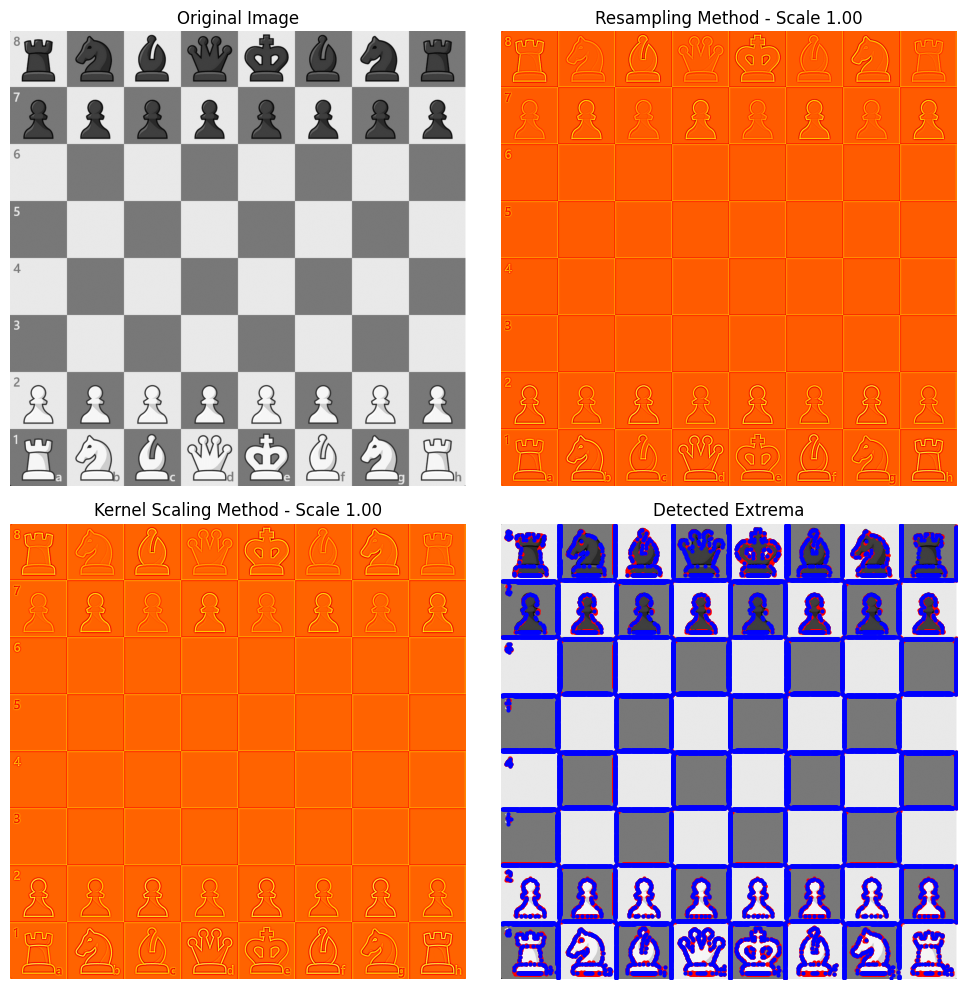

In [ ]:
demo_scale_detection("/content/chess.png")

In [ ]:

# What is a feature descriptor? (patch of intensity value vs histogram of oriented gradients). How do we match descriptors?
"""
feature descriptor is a representation of a local feature (e.g., a patch or keypoint) in an image.
It captures important information that allows the feature to be identified and matched in different images or at different scales.
Feature descriptors can describe things like the shape, texture, color, or gradient information of a region in an image.

Types of Feature Descriptors
Patch of Intensity Values:

This is a simple type of descriptor, where the feature is represented by the raw pixel values (intensities) within a local region or patch of the image.
The patch could be a square or circular region centered around a keypoint or feature location.
While this method is straightforward, it is sensitive to transformations such as scaling, rotation, and illumination changes, making it less robust for complex tasks.
Example: A 3x3 or 5x5 pixel patch around a feature in the image, represented by an array of intensity values.
Histogram of Oriented Gradients (HOG):

HOG is a more sophisticated descriptor, used especially in object detection and recognition tasks.
It captures the distribution of gradient directions in localized regions of the image. This makes it more robust to changes in lighting and small deformations.
To compute HOG, the image is divided into small cells (e.g., 8x8 pixels), and the gradients within each cell are calculated. These gradients are then represented as a histogram of gradient orientations.
The histograms from each cell are concatenated to form the final feature vector.
Example: Used in human detection or object recognition.
"""


# How is the keypoint detection done in SIFT, and how does this differ from Harris?
"""
1. Keypoint Detection in SIFT (Scale-Invariant Feature Transform)
SIFT was designed to find scale and rotation-invariant keypoints. The detection process involves the following steps:

Step 1: Scale-Space Construction
To make keypoint detection scale-invariant, SIFT creates a scale-space representation of the image.
This is done by applying Gaussian blurring at multiple scales
A series of blurred images are obtained, creating a Gaussian Pyramid where each octave (scale level) is a downsampled version of the previous one.

Step 2: Difference of Gaussians (DoG)
SIFT approximates the Laplacian of Gaussian (LoG) using the Difference of Gaussians (DoG)
The DoG helps in detecting blob-like structures in an image at different scales.

Step 3: Finding Local Extrema in Scale-Space
Keypoints are selected by identifying local extrema in the DoG images.
Each pixel in the DoG is compared with its 26 neighbors (8 in the same scale, 9 in the scale above, and 9 in the scale below).
If a pixel is a local maximum or minimum, it is considered a potential keypoint.

Step 4: Keypoint Refinement
To improve accuracy, SIFT applies Taylor series expansion to refine the keypoint position.
Keypoints with low contrast or lying on edges (determined using the Hessian matrix) are removed.

Step 5: Orientation Assignment
For rotation invariance, an orientation is assigned to each keypoint based on the local gradient directions.
A histogram of gradient orientations is computed in the keypoint’s neighborhood, and the dominant orientation is selected.
Key Properties of SIFT Detect


The Harris Corner Detector is based on the second-moment matrix (or structure tensor) and finds keypoints that are corners, which are areas with high intensity variations in both x and y directions.

Step 1: Compute Image Gradients
Compute derivatives in the x and y directions using Sobel filters

This gives the gradient strength at each pixel.
Step 2: Compute the Second-Moment Matrix (Structure Tensor)
For each pixel, construct the matrix.
where the summation is performed over a small window around each pixel.

Step 3: Compute the Harris Response
Using Eigenvalues of M, the response function is computed:
"""

# How does SIFT achieve orientation invariance?
"""

SIFT achieves orientation invariance by assigning a dominant direction to each keypoint based on local image gradients.
It computes gradient magnitudes and orientations in a small neighborhood around the keypoint. A histogram of orientations is built, and the most frequent direction is chosen as the keypoint's orientation.
All feature descriptors are then rotated relative to this dominant direction. This ensures that keypoints match correctly even if the image is rotated.
"""



# How is the SIFT descriptor built?

"""
SIFT builds its descriptor by first dividing a keypoint's local neighborhood into a 4×4 grid of smaller regions.
In each region, it calculates an 8-bin histogram of gradient directions. These histograms capture how edges are oriented in different parts of the neighborhood.
All 16 histograms are combined into a single 128-dimensional vector. This vector is then normalized to make it more robust to lighting changes.
"""

# What is the repeatability of the SIFT detector after rescaling 2? And for a 50-degree viewpoint change?

"""
The repeatability of the SIFT detector measures how well it detects the same keypoints after transformations.
After rescaling by a factor of 2, SIFT retains around 60-80% repeatability, meaning most keypoints can still be matched. For a 50-degree viewpoint change, repeatability drops but remains relatively high, typically above 50% in structured scenes.
SIFT is robust to scale and moderate viewpoint changes due to its multi-scale keypoint detection. However, extreme viewpoint changes can cause larger drops in repeatability."""

# Illustrate the 1st to 2nd closest ratio of SIFT detection: what’s the intuitive reasoning behind it? Where does the 0.8 factor come from?
"""
The 1st to 2nd closest ratio in SIFT helps filter out bad matches by comparing the best and second-best descriptor matches for a keypoint.
If the best match is much better (low ratio), it is likely a correct match; otherwise, it may be ambiguous or incorrect.
Intuitively, good matches should stand out clearly, while bad matches will have similar alternatives.
Lowe's original paper suggests using a threshold (e.g., 0.8), meaning the best match must be at least 20% better than the second-best. This helps remove false matches caused by noise or repetitive patterns.

“A threshold of 0.8 eliminates
90% of the false matches while
discarding less than 5% of the
correct matches.”

"""
# How does the FAST detector work? What are its pros and cons compared with Harris?

"""
The FAST detector works by checking if a pixel is a corner based on its intensity difference from surrounding pixels in a circular pattern.
If a set number of these pixels (e.g., 9 out of 16) are much brighter or darker than the center, it is marked as a corner. Pros: FAST is much faster than Harris because it avoids complex calculations.
Cons: It lacks scale information and is more sensitive to noise, while Harris provides a more robust corner response.
However, FAST is preferred in real-time applications where speed is critical.
"""


